In [43]:
import matplotlib.pyplot as plt 
import numpy as np 
import scipy 
import pandas as pd
import timeit
from matplotlib import ticker, cm

In [3]:
def conjugate_gradient(x0, f, grad, hess, max_iter=100, tol=1e-8):
    all_x_i = [x0[0]]
    all_y_i = [x0[1]]
    all_f_i = [f(x0)]
    x_i = x0
    r_i = grad(x0)
    p_i = -r_i
    for i in range(max_iter):
        a_i = - r_i.T @ p_i / (p_i.T @ hess(x_i) @ p_i)
        x_i_new = x_i + a_i * p_i
        r_i_new = grad(x_i_new)
        b_i = (r_i_new.T @ hess(x_i) @ p_i) / (p_i.T @ hess(x_i) @ p_i)
        p_i_new = -r_i_new + b_i * p_i
        x_i, r_i, p_i = x_i_new, r_i_new, p_i_new
        all_x_i.append(x_i[0])
        all_y_i.append(x_i[1])
        all_f_i.append(f(x_i))
    if np.sqrt(np.sum(r_i_new**2)) < tol:
        break
    return all_x_i, all_y_i, all_f_i


In [4]:
def newtons_method(x0, f, grad, hess, max_iter=100, max_back=10, tol=1e-8):
    all_x_i = [x0[0]]
    all_y_i = [x0[1]]
    all_f_i = [f(x0)]
    x_i = x0
    for i in range(max_iter):
        g_i = grad(x_i)
        step = - np.linalg.solve(hess(x_i), g_i)
        for j in range(max_back):
            new_x_i = x_i + step
            new_f_i = f(new_x_i)
            if (new_f_i < all_f_i[-1]):
                break
            step /= 2
        x_i, f_i = new_x_i, new_f_i
        all_x_i.append(x_i[0])
        all_y_i.append(x_i[1])
        all_f_i.append(f_i)
        if np.sqrt(np.sum(g_i**2)) < tol:
            break
    return all_x_i, all_y_i, all_f_i

In [170]:
def plot_2d_traj( x_lim, y_lim, f, trj=None, tle="", nd=10) : 
    x = np.linspace(x_lim[0], x_lim[1], 100) 
    y = np.linspace(y_lim[0], y_lim[1], 100)
    X, Y = np.meshgrid(x, y)
    fdata = f((X,Y))
    surf = plt.contour(X, Y, fdata, nd)
    plt.colorbar(surf, shrink=0.5)
    plt.clabel(surf, fmt="%2.1f", use_clabeltext=True)
    if trj : 
        plt.plot(trj[0], trj[1], "r-o", label=r"$f(x_k + \alpha p_k)$")
    plt.title(tle)
    

In [39]:
def mk_quad(epsilon=0.3): 
    f = lambda x : 0.33*(x[0]**2 + (epsilon**2)*(x[1]**2))
    grad = lambda x: np.array([0.66*x[0], 0.66*(epsilon**2)*x[1]])
    hess = lambda x: np.array([[0.66, 0.], [0, 0.66*(epsilon**2)]])
    return f, grad, hess

In [13]:
def define_methods(x0, f, grad, hess, tol=1e-8):
    return {
    "naive_newton":    lambda: newtons_method(x0, f, grad, hess, tol=tol),
    "naive_cg":        lambda: conjugate_gradient(x0, f, grad, hess, tol=tol),
    "cg":              lambda: scipy.optimize.minimize(f, x0, jac=grad, method="CG", tol=tol),
    "newton-cg":       lambda: scipy.optimize.minimize(f, x0, jac=grad, hess=None, method="Newton-CG", tol=tol),
    "newton-cg w/ H":  lambda: scipy.optimize.minimize(f, x0, jac=grad, hess=hess, method="Newton-CG", tol=tol),
    "bfgs":            lambda: scipy.optimize.minimize(f, x0, jac=grad, method="BFGS", tol=tol),
    "bfgs w/o G":      lambda: scipy.optimize.minimize(f, x0, method="BFGS", tol=tol),
    "l-bfgs":          lambda: scipy.optimize.minimize(f, x0, method="L-BFGS-B", tol=tol),
    "nelder-mead":     lambda: scipy.optimize.minimize(f, x0, method="Nelder-Mead", tol=tol)
    }

In [145]:
x0 = (1.6, 1.1)
f, grad, hess = mk_quad(0.7)
methods = define_methods(x0, f, grad, hess)
df = pd.DataFrame({
  key: timeit.Timer(methods[key]).repeat(10, 100) for key in methods
})
df

,naive_newton,naive_cg,cg,newton-cg,newton-cg w/ H,bfgs,bfgs w/o G,l-bfgs,nelder-mead
0,0.011200,0.003721,0.010967,0.022598,0.019150,0.028408,0.058574,0.027486,0.104490
1,0.003912,0.003558,0.010470,0.022286,0.019123,0.027850,0.058698,0.027110,0.105926
2,0.004000,0.003645,0.009809,0.022276,0.019043,0.027527,0.059572,0.027051,0.105210
3,0.004016,0.003524,0.009255,0.022283,0.019988,0.026623,0.058237,0.027077,0.104311
4,0.003850,0.003490,0.008524,0.022380,0.020245,0.026580,0.060357,0.027013,0.104226
5,0.003843,0.003524,0.008560,0.022228,0.020201,0.026560,0.059347,0.027086,0.104198
6,0.003795,0.003270,0.008491,0.022232,0.020332,0.026542,0.058301,0.026994,0.106898
7,0.003823,0.003231,0.008495,0.022251,0.019937,0.026554,0.058509,0.027084,0.107963
8,0.003834,0.003092,0.008440,0.022207,0.020224,0.026915,0.057936,0.027026,0.104866
9,0.003791,0.002949,0.008503,0.022201,0.020295,0.026691,0.057838,0.027030,0.104383


In [146]:
import seaborn as sns 

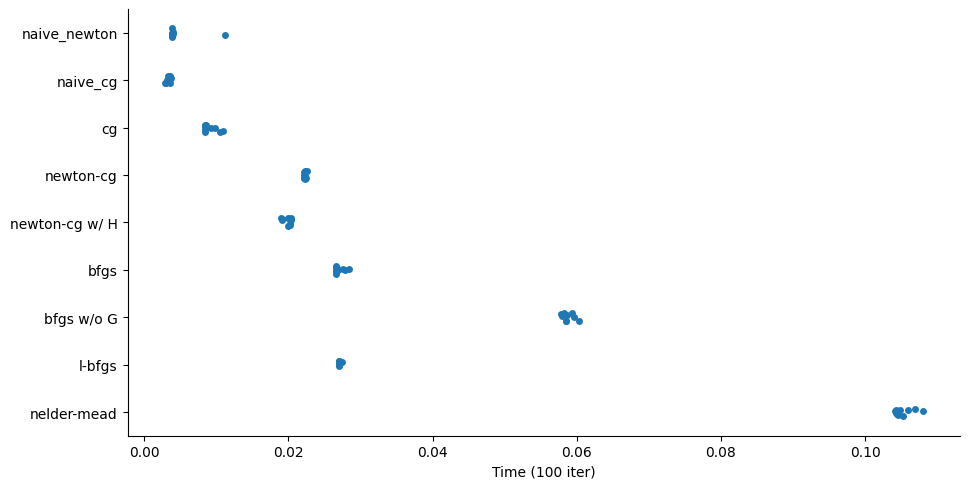

In [147]:
g = sns.catplot(data=df.melt(), y="variable", x="value", aspect=2)
g.ax.set_xlabel("Time (100 iter)")
g.ax.set_ylabel("")
plt.savefig("../images/method_timing.pdf")
plt.show()

In [190]:
def mk_rosenbrock(a=None): 
    f = lambda x : (1.-x[0])**2 + 100*(x[-1]-x[0]**2)**2
    grad = lambda x: np.array([-2*(1-x[0])-400*x[0]*(x[-1]-x[0]**2), 200*(x[-1] - x[0]**2)])
    hess = lambda x: np.array([[2-400*(x[-1] - 3*x[0]), -400*x[0]], [-400*x[0], 200.]])
    return f, grad, hess

In [149]:
def time_cost_func(x0, name, cost_func, *args):
    x0 = (1.6, 1.1)  
    f, grad, hess = cost_func(*args)
    methods = define_methods(x0, f, grad, hess)
    return ( pd.DataFrame({
      key: timeit.Timer(methods[key]).repeat(10, 20) for key in methods
    }).melt().assign(cost_func = name))
    
df = pd.concat([ time_cost_func(x0, "Well-cond quad", mk_quad, 0.7),
                time_cost_func(x0, "Ill-cond quad",
                               mk_quad, 0.02),time_cost_func(x0, "Rosenbrock", mk_rosenbrock)])



In [150]:
df

,variable,value,cost_func
0,naive_newton,0.002345,Well-cond quad
1,naive_newton,0.002425,Well-cond quad
2,naive_newton,0.003713,Well-cond quad
3,naive_newton,0.004893,Well-cond quad
4,naive_newton,0.001276,Well-cond quad
...,...,...,...
85,nelder-mead,0.021970,Rosenbrock
86,nelder-mead,0.021971,Rosenbrock
87,nelder-mead,0.021734,Rosenbrock
88,nelder-mead,0.021644,Rosenbrock


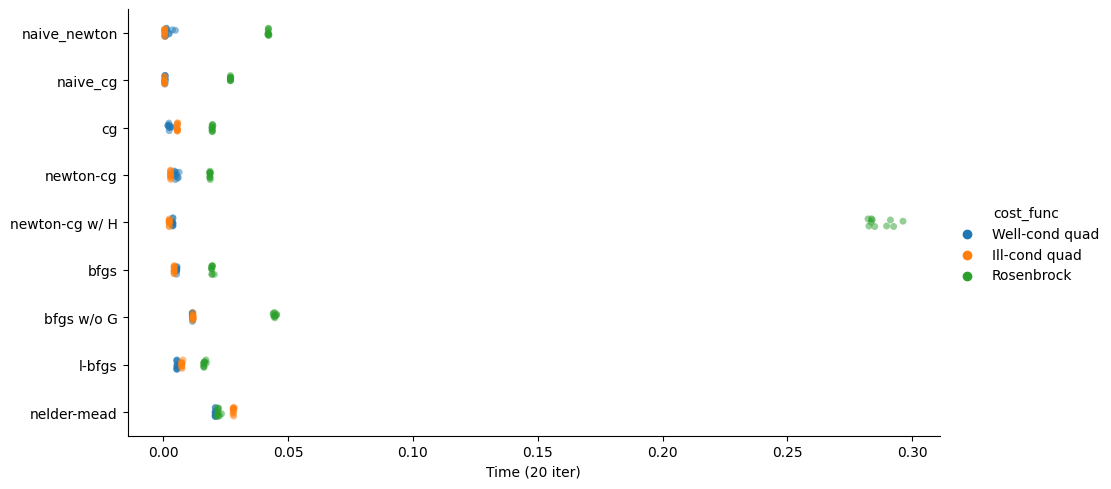

In [151]:
g = sns.catplot(data=df, y="variable", x="value", hue="cost_func", alpha=0.5, aspect=2)
g.ax.set_xlabel("Time (20 iter)")
g.ax.set_ylabel("")
plt.savefig("../images/timing_across_cf.pdf")
plt.show()

In [181]:
def plot_2d_traj2( x_lim, y_lim, f, trj=None, tle="", nd=30) : 
    x = np.linspace(x_lim[0], x_lim[1], 100) 
    y = np.linspace(y_lim[0], y_lim[1], 100)
    X, Y = np.meshgrid(x, y)
    fdata = f((X,Y))
    surf = plt.contour(X, Y, fdata,nd, locator=plt.LogLocator())
    fmt = ticker.LogFormatterMathtext()
    fmt.create_dummy_axis()
    plt.colorbar(surf, shrink=0.9)
    plt.clabel(surf,surf.levels,use_clabeltext=True,fmt=fmt)
    if trj : 
        plt.plot(trj[0], trj[1], "r-o", label=r"$f(x_k + \alpha p_k)$")
    plt.title(tle)

In [133]:
def conjugate_gradient_scipy(x0, f, grad, tol=1e-8):
    all_x_i = [x0[0]]
    all_y_i = [x0[1]]
    all_f_i = [f(x0)]
    def store(X):
        x, y = X
        all_x_i.append(x)
        all_y_i.append(y)
        all_f_i.append(f(X))
    scipy.optimize.minimize(
      f, x0, jac=grad, method="CG", 
      callback=store, tol=tol
    )
    return all_x_i, all_y_i, all_f_i


def grad_desc_2d(x0, f, grad, step, tau=0.5, max_step=100, max_back=10, tol = 1e-6):
    x_i = x0
    all_x_i = [x_i[0]]
    all_y_i = [x_i[1]]
    all_f_i = [f(x_i)]
    for i in range(max_step):
        dx_i = grad(x_i)
        for j in range(max_back):
            new_x_i = x_i - dx_i * step
            new_f_i = f(new_x_i)
            if (new_f_i < all_f_i[-1]):
                break
            step = step * tau
        x_i, f_i = new_x_i, new_f_i
        all_x_i.append(x_i[0])
        all_y_i.append(x_i[1])
        all_f_i.append(f_i)
        if np.sqrt(np.sum(dx_i**2)) < tol:
            break
    return all_x_i, all_y_i, all_f_i


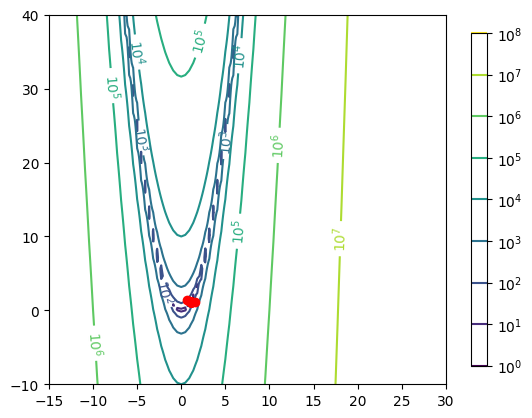

In [189]:
f, grad, hess = mk_rosenbrock()
opt = grad_desc_2d((1.6, 1.1), f, grad, step=0.25)
plot_2d_traj2((-15,30), (-10,40), f, trj=opt, nd=50)

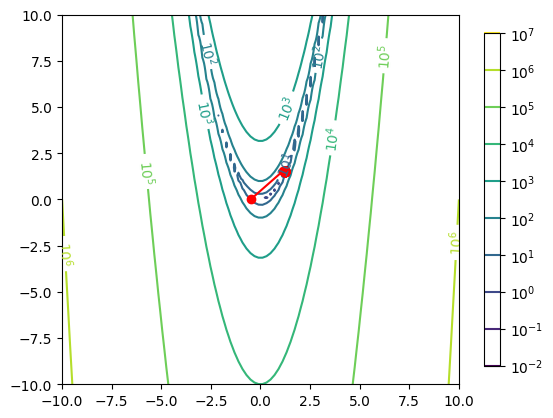

In [180]:
f, grad, hess = mk_rosenbrock()
opt = grad_desc_2d((-0.5, 0), f, grad, step=1)
plot_2d_traj2((-10,10), (-10,10), f, trj=opt)

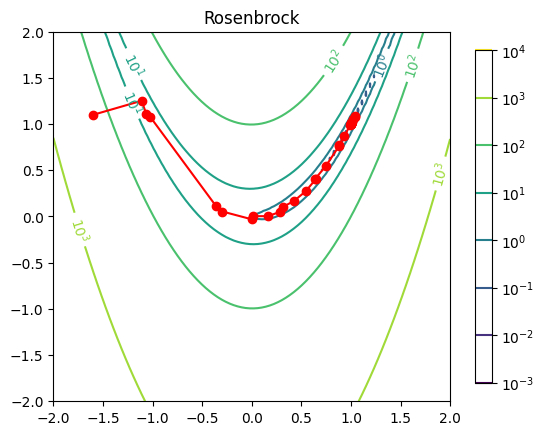

In [131]:
f, grad, hess = mk_rosenbrock()
opt = conjugate_gradient_scipy((-1.6, 1.1), f, grad)
plot_2d_traj2((-2,2), (-2,2), f, tle="Rosenbrock", trj=opt)

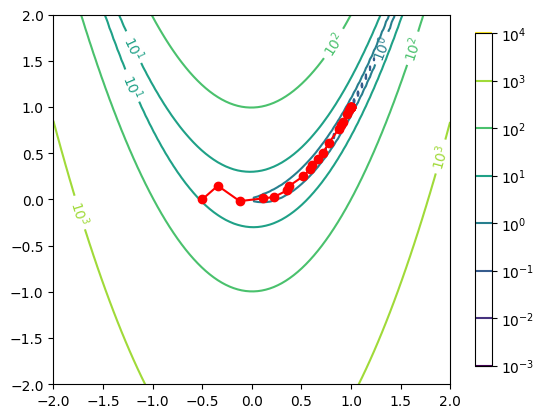

In [117]:
f, grad, hess = mk_rosenbrock()
opt = conjugate_gradient_scipy((-0.5, 0), f, grad)
plot_2d_traj2((-2,2), (-2,2), f, trj=opt)

In [119]:
import cProfile
f, grad, hess = mk_quad(0.7)
def run():
    for i  in range(100):
        scipy.optimize.minimize(fun = f, x0 = (1.6, 1.1), jac=grad, method="BFGS", tol=1e-11)
cProfile.run('run()', sort="tottime")

         114904 function calls in 0.094 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.019    0.000    0.092    0.001 _optimize.py:1318(_minimize_bfgs)
    14200    0.010    0.000    0.035    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     4800    0.007    0.000    0.007    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      900    0.004    0.000    0.037    0.000 _linesearch.py:91(scalar_search_wolfe1)
     2600    0.004    0.000    0.018    0.000 _optimize.py:235(vecnorm)
     2000    0.003    0.000    0.008    0.000 numeric.py:2407(array_equal)
     2700    0.003    0.000    0.009    0.000 fromnumeric.py:69(_wrapreduction)
     5100    0.003    0.000    0.010    0.000 <__array_function__ internals>:177(dot)
      900    0.002    0.000    0.015    0.000 _linesearch.py:77(derphi)
     2100    0.002    0.000    0.003    0.000 shape_base.py:23(atleast_1d)
      900    0.0

In [121]:
def run():
    for i  in range(100):
        scipy.optimize.minimize(fun = f, x0 = (1.6, 1.1), method="Nelder-Mead", tol=1e-11)
cProfile.run('run()', sort="tottime")

         533304 function calls in 0.282 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.095    0.001    0.279    0.003 _optimize.py:708(_minimize_neldermead)
    67800    0.019    0.000    0.109    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    19400    0.019    0.000    0.019    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    18600    0.017    0.000    0.058    0.000 _optimize.py:564(function_wrapper)
    29400    0.011    0.000    0.028    0.000 fromnumeric.py:51(_wrapfunc)
    18600    0.011    0.000    0.011    0.000 3882360833.py:2(<lambda>)
    19600    0.009    0.000    0.009    0.000 {method 'take' of 'numpy.ndarray' objects}
    19600    0.008    0.000    0.041    0.000 <__array_function__ internals>:177(take)
    18600    0.008    0.000    0.025    0.000 <__array_function__ internals>:177(copy)
     9900    0.008    0.000    0.024    0.000 fromnumeric.py:69(_w

In [122]:
f, grad, hess = mk_quad(0.7)

In [124]:
scipy.optimize.minimize(fun = f, x0 = (1.6, 1.1), jac=grad, method="BFGS")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.2739256453439168e-11
        x: [-5.318e-07 -8.843e-06]
      nit: 6
      jac: [-3.510e-07 -2.860e-06]
 hess_inv: [[ 1.515e+00 -3.438e-03]
            [-3.438e-03  3.035e+00]]
     nfev: 7
     njev: 7

In [126]:
scipy.optimize.minimize(fun = f, x0 = (1.6, 1.1), jac=grad, hess=hess, method="Newton-CG")

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.94639295004635e-36
       x: [ 0.000e+00  3.469e-18]
     nit: 5
     jac: [ 0.000e+00  1.122e-18]
    nfev: 5
    njev: 5
    nhev: 5

In [153]:
def run_collect(name, x0, cost_func, *args, tol=1e-8, skip=[]):
    f, grad, hess = cost_func(*args)
    methods = define_methods(x0, f, grad, hess, tol)
    res = []
    for method in methods:
        if method in skip:
            continue
        x = methods[method]()
        d = {
          "name":    name,
          "method":  method,
          "nit":     x["nit"],
          "nfev":    x["nfev"],
          "njev":    x.get("njev"),
          "nhev":    x.get("nhev"),
          "success": x["success"],
          "message": x["message"]
        }
        res.append( pd.DataFrame(d, index=[1]) )

    return pd.concat(res)



In [154]:
df = pd.concat([
  run_collect(name, (1.6, 1.1), cost_func, arg, skip=['naive_newton', 'naive_cg']) 
  for name, cost_func, arg in zip(
    ("Well-cond quad", "Ill-cond quad", "Rosenbrock"), 
    (mk_quad, mk_quad, mk_rosenbrock), 
    (0.7,0.02, None)
  )
])

In [155]:
df

,name,method,nit,nfev,njev,nhev,success,message
1,Well-cond quad,cg,2,5,5,None,True,Optimization terminated successfully.
1,Well-cond quad,newton-cg,5,6,13,0,True,Optimization terminated successfully.
1,Well-cond quad,newton-cg w/ H,5,5,5,5,True,Optimization terminated successfully.
1,Well-cond quad,bfgs,8,9,9,None,True,Optimization terminated successfully.
1,Well-cond quad,bfgs w/o G,8,27,9,None,True,Optimization terminated successfully.
1,Well-cond quad,l-bfgs,6,21,7,None,True,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
1,Well-cond quad,nelder-mead,76,147,None,None,True,Optimization terminated successfully.
1,Ill-cond quad,cg,9,17,17,None,True,Optimization terminated successfully.
1,Ill-cond quad,newton-cg,3,4,9,0,True,Optimization terminated successfully.
1,Ill-cond quad,newton-cg w/ H,3,3,3,3,True,Optimization terminated successfully.


In [156]:
df.drop(["message"], axis=1)

,name,method,nit,nfev,njev,nhev,success
1,Well-cond quad,cg,2,5,5,None,True
1,Well-cond quad,newton-cg,5,6,13,0,True
1,Well-cond quad,newton-cg w/ H,5,5,5,5,True
1,Well-cond quad,bfgs,8,9,9,None,True
1,Well-cond quad,bfgs w/o G,8,27,9,None,True
1,Well-cond quad,l-bfgs,6,21,7,None,True
1,Well-cond quad,nelder-mead,76,147,None,None,True
1,Ill-cond quad,cg,9,17,17,None,True
1,Ill-cond quad,newton-cg,3,4,9,0,True
1,Ill-cond quad,newton-cg w/ H,3,3,3,3,True


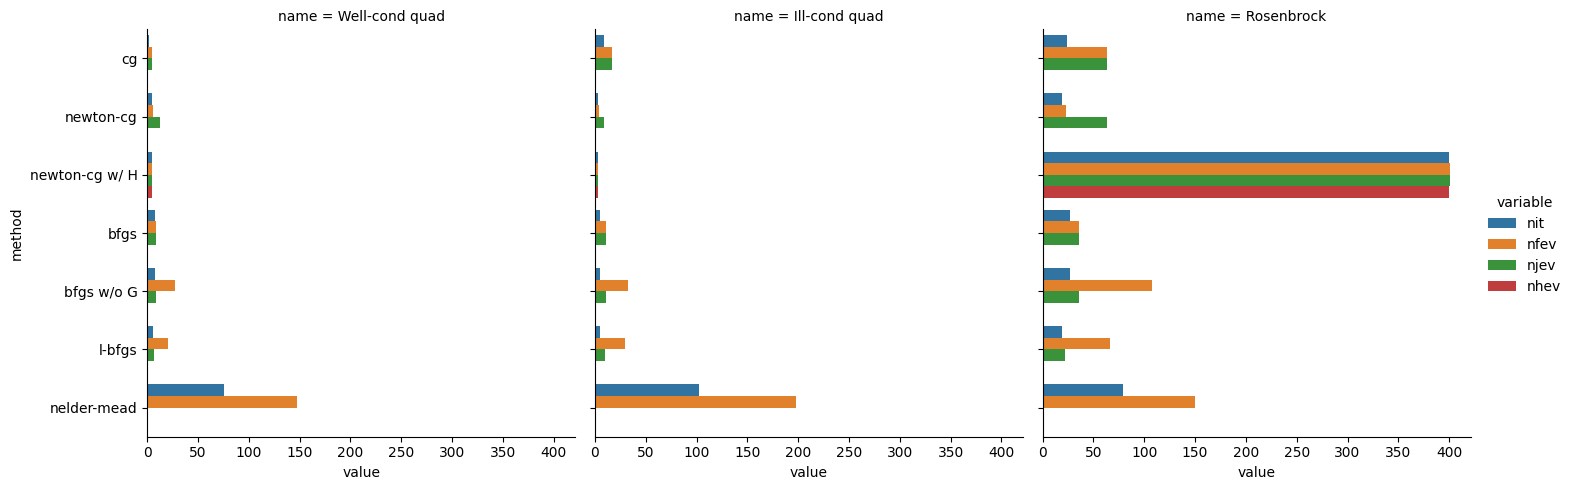

In [157]:
sns.catplot(
  y = "method", x = "value", hue = "variable", col="name", kind="bar",
  data = df.melt(id_vars=["name","method"], value_vars=["nit", "nfev", "njev", "nhev"]).astype({"value": "float64"})
)
plt.savefig("../images/collect.pdf")

# Exercise 1

In [159]:
def f(x) : 
    return np.exp(x[0] - 1)+np.exp(-x[1]+1)+(x[0]-x[1])**2

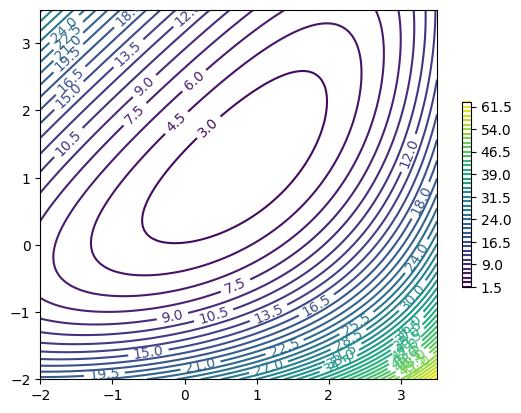

In [171]:
plot_2d_traj((-2,3.5), (-2,3.5), f, nd=50)
plt.savefig("../images/exercise.pdf")

In [194]:
import timeit
from scipy import optimize

def f(x): 
    return np.exp(x[0]-1) + np.exp(-x[1]+1) + (x[0]-x[1])**2

def grad(x):
    return [
    np.exp(x[0]-1) + 2 * (x[0]-x[1]),
    -np.exp(-x[1]+1) - 2 * (x[0]-x[1])
    ]

def hess(x):
    return [
    [ np.exp(x[0]-1) + 2, -2                  ],
    [ -2                , np.exp(-x[1]+1) + 2 ]
    ]

x0 = [0, 0]

optimize.minimize(fun=f, x0=x0, jac=grad, method="BFGS")
optimize.minimize(fun=f, x0=x0, jac=grad, method="CG")
optimize.minimize(fun=f, x0=x0, jac=grad, method="Newton-CG")
optimize.minimize(fun=f, x0=x0, jac=grad, hess=hess, method="Newton-CG")
optimize.minimize(fun=f, x0=x0, jac=grad, method="Nelder-Mead")

timeit.Timer(lambda: optimize.minimize(fun=f, x0=x0, jac=grad, method="BFGS")).repeat(1, 100)
timeit.Timer(lambda: optimize.minimize(fun=f, x0=x0, jac=grad, method="CG")).repeat(1, 100)
timeit.Timer(lambda: optimize.minimize(fun=f, x0=x0, jac=grad, method="Newton-CG")).repeat(1, 100)
timeit.Timer(lambda: optimize.minimize(fun=f, x0=x0, jac=grad, hess=hess, method="Newton-CG")).repeat(1, 100)
timeit.Timer(lambda: optimize.minimize(fun=f, x0=x0, method="Nelder-Mead")).repeat(1, 100)

/Users/lemerleau/miniforge3/envs/fmi08icds/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


[0.10732058295980096]

In [172]:


rng = np.random.default_rng(seed=1234)
x0s = rng.uniform(-2,2, (100,2))
df = pd.concat([
  run_collect(name, x0, cost_func, arg, skip=['naive_newton', 'naive_cg']) 
  for name, cost_func, arg in zip(
    ("Well-cond quad", "Ill-cond quad", "Rosenbrock"), 
    (mk_quad, mk_quad, mk_rosenbrock), 
    (0.7,0.02, None)
  )
  for x0 in x0s
])



In [173]:
df.drop(["message"], axis=1)

,name,method,nit,nfev,njev,nhev,success
1,Well-cond quad,cg,2,5,5,None,True
1,Well-cond quad,newton-cg,5,6,13,0,True
1,Well-cond quad,newton-cg w/ H,5,5,5,5,True
1,Well-cond quad,bfgs,6,7,7,None,True
1,Well-cond quad,bfgs w/o G,6,21,7,None,True
...,...,...,...,...,...,...,...
1,Rosenbrock,newton-cg w/ H,142,191,191,142,True
1,Rosenbrock,bfgs,39,48,48,None,True
1,Rosenbrock,bfgs w/o G,39,141,47,None,True
1,Rosenbrock,l-bfgs,24,81,27,None,True


/Users/lemerleau/miniforge3/envs/fmi08icds/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/lemerleau/miniforge3/envs/fmi08icds/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/lemerleau/miniforge3/envs/fmi08icds/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/lemerleau/miniforge3/envs/fmi08icds/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/lemerleau/miniforge3/envs/fmi08icds/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/lemerleau/miniforge3/envs/fmi08icds/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:

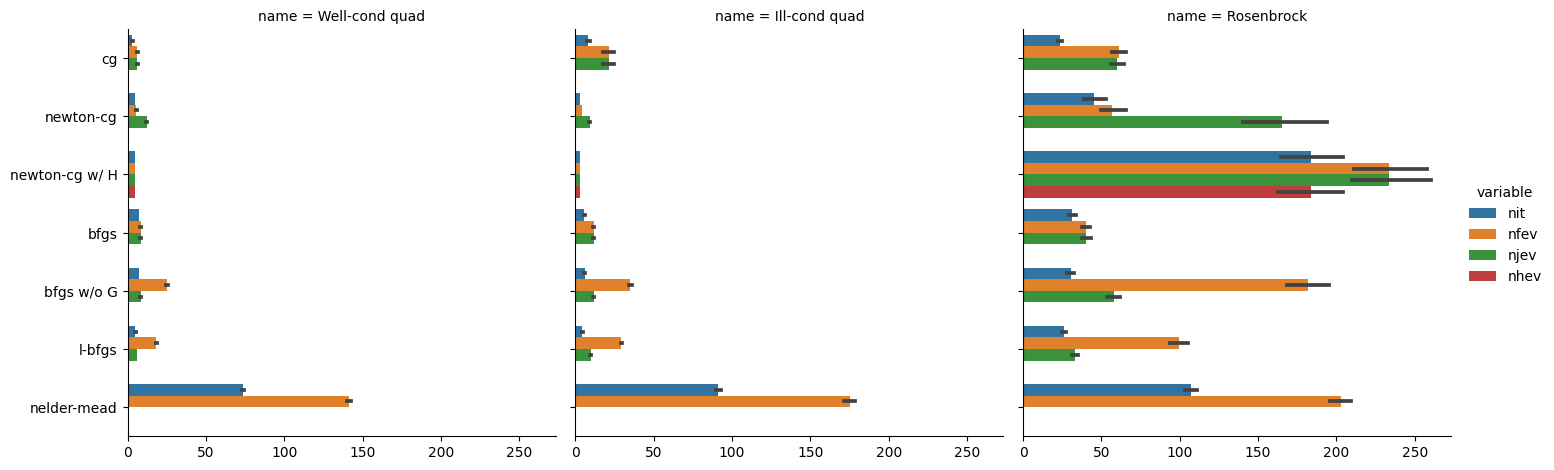

In [176]:
sns.catplot(
  y = "method", x = "value", hue = "variable", col="name", kind="bar",
  data = df.melt(id_vars=["name","method"], value_vars=["nit", "nfev", "njev", "nhev"]).astype({"value": "float64"})
).set(xlabel="", ylabel="")
plt.savefig("random_start.pdf")

/Users/lemerleau/miniforge3/envs/fmi08icds/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


[0.10683991713449359]

In [195]:
s = str()

In [197]:
str.__mro__

(str, object)